In [1]:
'''
2IMA35 Massively Parallel Algorithms Report 1
... and Jacco Kiezebrink (1237101)
''';


'''
TODO:
- Current version of Kees' code uses vertex sampling, has to be converted to edge sampling
- WeightingMethods INCIDENT_EDGES_THE_SAME(_REVERSED) do not work yet
- Current output is just an MST, not sure if we should change it to do something with the clustering or keep it this way as the 
    algorithm doesn't change only the way we show the output
- runtime is now kept over entire reduce_edges (i.e. the spark job) function, could also do it inside to not take into account the overhead of the spark job?
''';

In [2]:
import math
import random
import time
import numpy as np
from enum import Enum
from itertools import combinations, groupby

import networkx as nx
import matplotlib.pyplot as plt

import findspark
findspark.init()
from pyspark import RDD, SparkConf, SparkContext

In [3]:
# https://stackoverflow.com/questions/61958360/how-to-create-random-graph-where-each-node-has-at-least-1-edge-using-networkx
class WeightingMethod(Enum):
    RANDOM = 0
    ALL_THE_SAME = 1
    UNIQUE = 2
    UNIQUE_REVERSED = 3
    INCIDENT_EDGES_THE_SAME = 4
    INCIDENT_EDGES_THE_SAME_REVERSED = 5
    # CLUSTER
    

def GenerateGraph(n:int = 0, sparsity:float = 0.0, seed:int = 100, w_method:WeightingMethod = 0, w_min:int = 1, w_max:int = 10):
    random.seed(seed)
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    max_nr_edges = (n * (n - 1)) / 2
    possible_edges = combinations(range(n), 2)  # all possible combination of edges, i.e. length is equal to max_nr_edges
    total_edges = round(max_nr_edges * sparsity)  # total edges that should be in the final graph
    existing_edges = []
    
    if w_method == WeightingMethod.UNIQUE_REVERSED.value:
        unique_weight_counter = max_nr_edges + 1
    elif w_method == WeightingMethod.INCIDENT_EDGES_THE_SAME_REVERSED.value:
        unique_weight_counter = n + 1
    else:
        unique_weight_counter = 1
    
    # Create graph with n vertices
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Creates a minimum spanning tree
    for _, node_edges in groupby(possible_edges, key=lambda x: x[0]):
        edge = list(node_edges)[0]
        existing_edges.append(edge)
        if w_method == WeightingMethod.RANDOM.value:
            G.add_edge(*edge, weight=random.randint(w_min, w_max))
        elif w_method == WeightingMethod.ALL_THE_SAME.value:
            G.add_edge(*edge, weight=1)
        elif w_method == WeightingMethod.UNIQUE.value:
            G.add_edge(*edge, weight=unique_weight_counter)
            unique_weight_counter += 1
        elif w_method == WeightingMethod.UNIQUE_REVERSED.value:
            G.add_edge(*edge, weight=unique_weight_counter)
            unique_weight_counter -= 1
        else:
            G.add_edge(*edge)  # or add edge without weight
        
    # add edges until the desired number is reached
    for edge in list(combinations(range(n), 2)):
        if edge not in existing_edges and G.number_of_edges() <= total_edges:
            existing_edges.append(edge)
            if w_method == WeightingMethod.RANDOM.value:
                G.add_edge(*edge, weight=random.randint(w_min, w_max))
            elif w_method == WeightingMethod.ALL_THE_SAME.value:
                G.add_edge(*edge, weight=1)
            elif w_method == WeightingMethod.UNIQUE.value:
                G.add_edge(*edge, weight=unique_weight_counter)
                unique_weight_counter += 1
            elif w_method == WeightingMethod.UNIQUE_REVERSED.value:
                G.add_edge(*edge, weight=unique_weight_counter)
                unique_weight_counter -= 1
            else:
                G.add_edge(*edge)  # or add edge without weight
                
    if w_method == WeightingMethod.INCIDENT_EDGES_THE_SAME.value or w_method == WeightingMethod.INCIDENT_EDGES_THE_SAME_REVERSED.value:
        degree_list = sorted([(node, G.degree(node)) for node in G.nodes()], key=lambda x: x[1], reverse=True)
        for node in degree_list:
            update = False
            for edge in G.edges(node[0]):
                if "weight" not in edge:
                    print(edge, G[edge[0]][edge[1]], unique_weight_counter, "weight" not in edge)
                    G[edge[0]][edge[1]]['weight'] = unique_weight_counter
                    #G[edge[1]][edge[0]]['weight'] = unique_weight_counter
                    update = True
            if update:
                if w_method == WeightingMethod.INCIDENT_EDGES_THE_SAME_REVERSED.value:
                    unique_weight_counter -= 1
                else:
                    unique_weight_counter += 1
                
    return G

In [4]:
# Functions to bridge between nx and the mst implementation
def nx_edges_to_tuples(G):
    result = []
    for edge in G.edges():
        result.append((edge[0], edge[1], G[edge[0]][edge[1]]["weight"]))
    return result

def mst_to_nx(edges):
    G = nx.Graph()
    G.add_nodes_from(range(len(edges)))
    for edge in edges:
        G.add_edge(edge[0], edge[1], weight = edge[2])
    return G    

In [5]:
def partition_edges(edges, k):
    """
    Partitioning of the edges in k smaller subsets
    """
    edge_sets = []
    random.shuffle(edges)
    edges = edges.copy()
    for i in range(len(edges)):
        if i < k:
            edge_sets.append([edges[i]])
        else:
            edge_sets[i % k].append(edges[i])
    return edge_sets

def find_mst(V, E):
    """
    finds the mst of graph G = (V, E)
    :param V: vertices V
    :param E: edges of the graph
    :return: the mst and edges not in the mst of the graph
    """
    vertices = set(V)
    E = sorted(E, key=lambda x: x[2])
    connected_component = set()
    mst = []
    remove_edges = set()
    while len(mst) < len(vertices) - 1 and len(connected_component) < len(vertices):
        if len(E) == 0:
            break
        change = False
        i = 0
        while i < len(E):
            if len(connected_component) == 0:
                connected_component.add(E[i][0])
                connected_component.add(E[i][1])
                mst.append(E[i])
                change = True
                E.remove(E[i])
                break
            else:
                if E[i][0] in connected_component:
                    if E[i][1] in connected_component:
                        remove_edges.add(E[i])
                        E.remove(E[i])
                    else:
                        connected_component.add(E[i][1])
                        mst.append(E[i])
                        E.remove(E[i])
                        change = True
                        break
                elif E[i][1] in connected_component:
                    if E[i][0] in connected_component:
                        remove_edges.add(E[i])
                        E.remove(E[i])
                    else:
                        connected_component.add(E[i][0])
                        mst.append(E[i])
                        E.remove(E[i])
                        change = True
                        break
                else:
                    i += 1
        if not change:
            if len(E) != 0:
                connected_component.add(E[0][0])
                connected_component.add(E[0][1])
                mst.append(E[0])
                E.remove(E[0])
    for edge in E:
        remove_edges.add(edge)
    if len(mst) != len(vertices) - 1 or len(connected_component) != len(vertices):
        print("Warning: parition cannot have a full MST! Missing edges to create full MST.")
        # print("Error: MST found cannot be correct \n Length mst: ", len(mst), "\n Total connected vertices: ",
        #       len(connected_component), "\n Number of vertices: ", len(vertices))
    return mst, remove_edges


def reduce_edges(vertices, E, c, epsilon):
    """
    Uses PySpark to distribute the computation of the MSTs,
    Randomly partition the edges into k subsets
    For every set, create the subgraph and find the MST in this graph
    Remove all edges from E that are not part of the MST in the subgraph
    :param vertices: vertices in the graph
    :param E: edges of the graph
    :param c: constant
    :param epsilon:
    :return:The reduced number of edges
    """
    conf = SparkConf().setAppName('MST_Algorithm')
    sc = SparkContext.getOrCreate(conf=conf)

    n = len(vertices)
    k = math.ceil(n ** ((c - epsilon) / 2))
    edge_sets = partition_edges(E, k)
    rdd = sc.parallelize(edge_sets).map(lambda x: (find_mst(vertices, x)))
    rdd_local = rdd.collect()

    mst = []
    removed_edges = set()
    for i in range(len(rdd_local)):
        mst.append(rdd_local[i][0])
        for edge in rdd_local[i][1]:
            removed_edges.add(edge)

    sc.stop()
    return mst, removed_edges


def remove_edges(E, removed_edges):
    """
    Removes the edges, which are removed when generating msts
    :param E: current edges
    :param removed_edges: edges to be removed
    :return: return the updated edge dict
    """
    for edge in removed_edges:
        E.remove(edge)
    return E


def create_mst(V, E, size, epsilon):
    """
    Creates the mst of the graph G = (V, E).
    As long as the number of edges is greater than n ^(1 + epsilon), the number of edges is reduced
    Then the edges that needs to be removed are removed from E and the size is updated.
    :param V: Vertices
    :param E: edges
    :param epsilon:
    :param size: number of edges
    :return: returns the reduced graph with at most np.power(n, 1 + epsilon) edges
    """
    n = len(V)
    c = math.log(size / n, n)
    round_counter = 0
    timings = []
    while size > np.power(n, 1 + epsilon):
        timestamp = time.time()
        print("\nC: ", c)
        round_counter += 1
        mst, removed_edges = reduce_edges(V, E, c, epsilon)
        #if plot_intermediate:
        #    plot_mst(vertex_coordinates, mst, True, False)
        E = remove_edges(E, removed_edges)
        print("Total edges removed in this iteration", len(removed_edges))
        size = size - len(removed_edges)
        print("New total of edges: ", size)
        c = (c - epsilon) / 2
        timings.append((time.time() - timestamp))
        print("Iter time:", time.time() - timestamp)
    # Now the number of edges is reduced and can be moved to a single machine
    print("#Communication Rounds =", round_counter)
    print("Average round runtime:", round(sum(timings) / len(timings), 2) if round_counter != 0 else 0)
    V = set(range(n))
    mst, removed_edges = find_mst(V, E)
    return mst

In [6]:
# Generate Graph
G = GenerateGraph(200, 101, 100)

# draw with edge weights
pos=nx.spring_layout(G)
print("Input Graph")
#nx.draw(G, pos);  # uncomment if you want to draw the graph
labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G,pos, edge_labels=labels);  # uncomment if you want to display edge weights
#plt.savefig(<wherever>)

Input Graph


In [7]:
# compute mst
mst = create_mst(list(G.nodes()), nx_edges_to_tuples(G), len(G.edges()), 1/8)


C:  0.8682299163897849
Total edges removed in this iteration 18308
New total of edges:  1592
Iter time: 61.86894178390503

C:  0.37161495819489243
Total edges removed in this iteration 1194
New total of edges:  398
Iter time: 19.560939073562622

C:  0.12330747909744622
Total edges removed in this iteration 199
New total of edges:  199
Iter time: 19.040210247039795
#Communication Rounds = 3
Average round runtime: 33.49


Output Graph


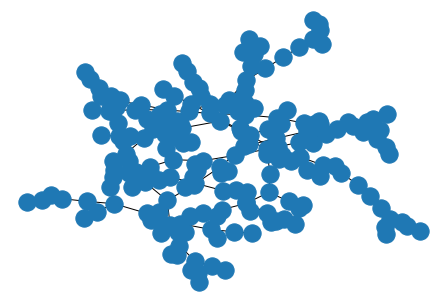

In [8]:
# Output graph
out_G = mst_to_nx(mst)
pos=nx.spring_layout(out_G)
print("Output Graph")
nx.draw(out_G, pos);
labels = nx.get_edge_attributes(out_G, 'weight')
#nx.draw_networkx_edge_labels(out_G, pos, edge_labels=labels);  # uncomment if you want to display weights
#plt.savefig(<wherever>)